Reading CNV_Kit output file to understand the file and to make a figure

In [1]:
cd /mnt/Sdrive/SCIENCE-BIO-BRSDriveCircularVision/Judith/Projects/CRC/CNV/Bedfiles/

/mnt/Sdrive/SCIENCE-BIO-BRSDriveCircularVision/Judith/Projects/CRC/CNV/Bedfiles


log2: The log2 ratio value of the segment covering the gene, i.e. weighted mean of all bins covered by the whole segment, not just this gene.
depth: Weighted mean of un-normalized read depths across all this gene’s bins.
weight: Sum of this gene’s bins’ weights.

seg_weight: The sum of the weights of the bins supporting the segment.
seg_probes: The number of probes supporting the segment.
Confidence interval of the segment mean (--ci), estimated by bootstrap (100 resamplings) of the bin-level log2 ratio values within the segment. The upper and lower bounds are output as separate columns ci_lo and ci_hi.

In [2]:
import pandas as pd
import pybedtools as pbt
import numpy as np
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
ctt = pd.read_csv('/mnt/Sdrive/SCIENCE-BIO-BRSDriveCircularVision/Judith/Projects/Reference_genome/hg38_CanonicalCHR_MBsizes.bed',sep='\t',header=None)
ctt.columns = ['Chromosomes', 'binstart', 'binend']

In [4]:
ctt

,Chromosomes,binstart,binend
0,chr1,0,1000000
1,chr1,1000000,2000000
2,chr1,2000000,3000000
3,chr1,3000000,4000000
4,chr1,4000000,5000000
...,...,...,...
3039,chrX,152000000,153000000
3040,chrX,153000000,154000000
3041,chrX,154000000,155000000
3042,chrX,155000000,156000000


In [5]:
for n,i in enumerate(ctt.index):
    b = ':'.join((str(ctt.loc[i,'Chromosomes']),'-'.join((str(ctt.loc[i,'binstart']),str(ctt.loc[i,'binend'])))))
    ctt.loc[i,'gbin'] = b
    ctt.loc[i,'xpos'] = n+1

/tmp/ipykernel_1055/226135230.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'chr1:0-1000000' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  ctt.loc[i,'gbin'] = b


In [6]:
pt = ctt.Chromosomes.value_counts()

In [7]:
chromosomes_order = ['chr{}'.format(i) for i in range(1, 23)] + ['chrX']

# Reindex the series with the desired order
sorted_chromosome_series = pt.reindex(chromosomes_order)


In [8]:
previous_value = 0
for chromosome in sorted_chromosome_series.index:
    sorted_chromosome_series[chromosome] += previous_value
    previous_value = sorted_chromosome_series[chromosome]

In [9]:
ctt.index=ctt.gbin

In [10]:
ctt

,Chromosomes,binstart,binend,gbin,xpos
gbin,,,,,
chr1:0-1000000,chr1,0,1000000,chr1:0-1000000,1.0
chr1:1000000-2000000,chr1,1000000,2000000,chr1:1000000-2000000,2.0
chr1:2000000-3000000,chr1,2000000,3000000,chr1:2000000-3000000,3.0
chr1:3000000-4000000,chr1,3000000,4000000,chr1:3000000-4000000,4.0
chr1:4000000-5000000,chr1,4000000,5000000,chr1:4000000-5000000,5.0
...,...,...,...,...,...
chrX:152000000-153000000,chrX,152000000,153000000,chrX:152000000-153000000,3040.0
chrX:153000000-154000000,chrX,153000000,154000000,chrX:153000000-154000000,3041.0
chrX:154000000-155000000,chrX,154000000,155000000,chrX:154000000-155000000,3042.0


In [11]:
#columns = chromosome	start	end	gene	log2	depth	weight	ci_hi	ci_lo	probes	segment_weight	segment_probes

In [12]:
def chromosome_cnv(filename):
    chroms =pbt.BedTool('/mnt/Sdrive/SCIENCE-BIO-BRSDriveCircularVision/Judith/Projects/Reference_genome/hg38_CanonicalCHR_MBsizes.bed')
    t1 = pbt.BedTool(filename)
    dens = chroms.intersect(t1, wa =True, loj=True)
    bins = {}

    for i in tqdm(dens):
        b = ':'.join((i[0],'-'.join((i[1],i[2]))))
        if i[4] != '-1':
            if b not in bins:
                bins[b] = float(i[8])

            else:
                if bins[b] <float(i[8]):
                    bins[b] = float(i[8])

                else:
                    continue
    for i in chroms:
        b = ':'.join((i[0],'-'.join((i[1],i[2]))))
        if b not in bins:
            bins[b]=0
    return bins

In [13]:
fnames = glob('*.bed')

In [14]:
dtf = {}
for filea in fnames:
    fl =  filea.split('.')[0]
    dtf[fl] = chromosome_cnv(filea)


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 4689/4689 [00:00<00:00, 65209.19it/s]


In [15]:
df = pd.DataFrame(dtf)

In [16]:
df.describe()

,CRCtx026,CRCtx029,CRCtx040,CRCtx055,CRCtx053,CRCtx036,CRCtx027,CRCtx033,CRCtx054,CRCtx047,CRCtx028,CRCtx021
count,3044.000000,3044.000000,3044.000000,3044.000000,3044.000000,3044.000000,3044.000000,3044.000000,3044.000000,3044.000000,3044.000000,3044.000000
mean,-0.218396,-0.143461,-0.192258,-0.198742,-0.210991,-0.270422,-0.215151,-0.231521,-0.181113,-0.237007,-0.283990,-0.207869
std,1.930854,1.873752,1.987512,1.808380,1.930878,2.011870,2.005355,1.923086,1.966659,1.809718,2.034713,1.985577
min,-23.420900,-23.710400,-23.620800,-23.910000,-23.467000,-23.496800,-23.728600,-23.647900,-22.950700,-23.734900,-23.859600,-23.096800
25%,-0.043175,-0.061934,-0.041880,-0.055403,-0.101153,-0.197848,-0.108746,-0.357171,-0.133788,-0.327185,-0.305103,-0.134877
50%,0.019879,0.000000,0.008622,0.008206,0.013786,0.000000,0.000000,0.074219,0.017263,0.001951,0.006347,0.033281
75%,0.097729,0.312339,0.105804,0.098140,0.120015,0.170345,0.125689,0.295390,0.206183,0.073855,0.081548,0.273342
max,5.743980,5.712940,6.321080,6.897680,5.628820,5.545300,6.250870,6.543660,5.627700,3.273620,6.322830,6.304410


In [25]:
df

,CRCtx026,CRCtx029,CRCtx040,CRCtx055,CRCtx053,CRCtx036,CRCtx027,CRCtx033,CRCtx054,CRCtx047,CRCtx028,CRCtx021,Xpos
chr1:0-1000000,-0.157071,0.032018,-0.781829,-0.078174,-0.163742,-0.634414,-0.112402,-0.433232,-0.036448,0.130735,-0.002830,-0.128262,1.0
chr1:1000000-2000000,-0.152804,0.032018,-0.781829,-0.021339,-0.163742,-0.634414,-0.112402,-0.433232,-0.036448,-0.415981,-0.002830,-0.128262,2.0
chr1:2000000-3000000,0.067672,0.071337,-0.684721,0.073458,-0.046488,-0.040226,0.071098,-0.271293,0.096818,-0.327430,0.093991,-0.048089,3.0
chr1:3000000-4000000,0.067672,0.204736,-0.684721,0.073458,-0.046488,0.116869,0.197891,-0.271293,0.096818,-0.327430,0.093991,0.123585,4.0
chr1:4000000-5000000,0.020703,0.076112,-0.733711,0.073458,-0.046488,0.024902,0.095227,-0.271293,0.079439,-0.360787,0.093991,-0.052447,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
chrX:152000000-153000000,0.025740,0.276904,0.361082,-0.118763,-0.354451,-0.906524,-0.579680,-0.729818,0.517180,0.114478,-1.065000,0.110106,3040.0
chrX:153000000-154000000,0.025740,0.276904,0.361082,-0.118763,-0.354451,-0.906524,-0.579680,-0.885089,0.517180,0.114478,-1.065000,0.110106,3041.0
chrX:154000000-155000000,0.025740,0.276904,0.353186,-0.118763,-0.354451,-0.993029,-0.579680,-0.885089,0.517180,0.114478,-1.065000,0.110106,3042.0
chrX:155000000-156000000,-0.410962,-0.686172,0.022781,-1.038000,-1.384590,-1.959350,-0.590785,-2.202580,0.092195,-1.056740,-1.424380,-1.122460,3043.0


In [17]:
tst = []
for i in df.index:
    for j in df.columns:
        if df.loc[i,j]>0:
            tst.append([i,j])

In [18]:
for i in df.index:
    df.loc[i,'Xpos'] = ctt.loc[i,'xpos']

In [19]:
#215862
#2e665e
#477152
#617b45
#7f8437
#a18e35
#c49541
#e49d5e
#f6a784
#f9b3ab
#f8bfd1
#eecce1
#cp = {'CRCtx026':'#215862', 'CRCtx029':'#2e665e', 'CRCtx040':'#477152', 'CRCtx055':'#617b45', 'CRCtx053':'#7f8437',
#      'CRCtx036':'#a18e35', 'CRCtx027':'#c49541', 'CRCtx033':'#e49d5e', 'CRCtx054':'#f6a784', 'CRCtx047':'#f9b3ab',
#      'CRCtx028':'#f8bfd1', 'CRCtx021':'#eecce1'}

In [20]:
df =df.sort_values(by='Xpos')

In [34]:
def fig_generator(df, col_name, sorted_chromosome_series):
    fig, ax = plt.subplots(1, 1, figsize=(15,2))
    plt.subplots_adjust(left=0.3, right=0.9, bottom=0.3, top=0.9)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    g =sns.scatterplot(x = df.Xpos ,y = df[col_name],data = df,size=1, legend=False, c='#006400',linewidth=0 )
    plt.xticks(sorted_chromosome_series, labels=sorted_chromosome_series.index, size = 8, rotation = 90)
    ax.axhline(y=0, color='#666666')
    plt.ylim(-2,2)
    plt.xlim(-25,df['Xpos'].max()+25)
    plt.ylabel('Copy ratio (log2)')
    plt.title(i)
    plt.xlabel('MB bins')
    fname = i+'_MBbins_Corrected.pdf'
    plt.savefig(fname, dpi=100)
    plt.show()

CRCtx026


/home/judith/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/judith/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/judith/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/judith/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDty

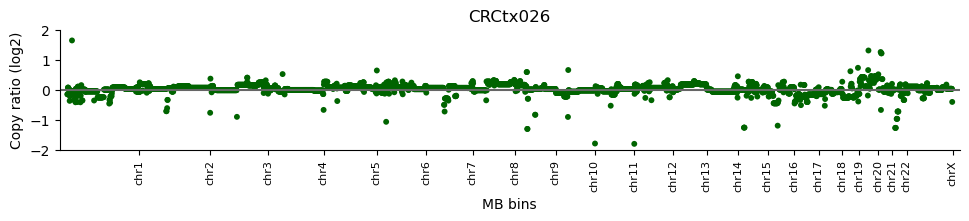

CRCtx029


/home/judith/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/judith/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/judith/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/judith/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDty

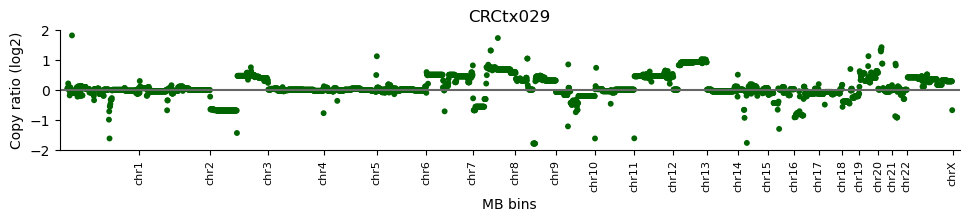

CRCtx040


/home/judith/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/judith/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/judith/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/judith/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDty

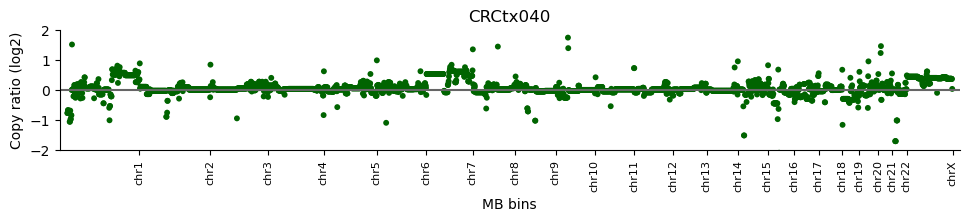

CRCtx055


/home/judith/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/judith/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/judith/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/judith/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDty

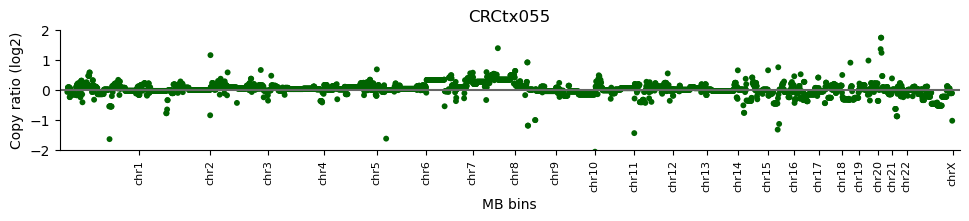

CRCtx053


/home/judith/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/judith/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/judith/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/judith/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDty

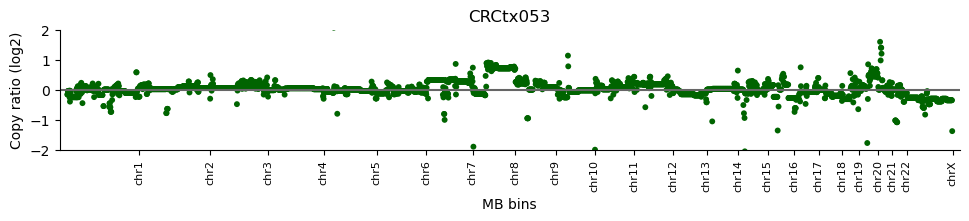

CRCtx036


/home/judith/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/judith/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/judith/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/judith/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDty

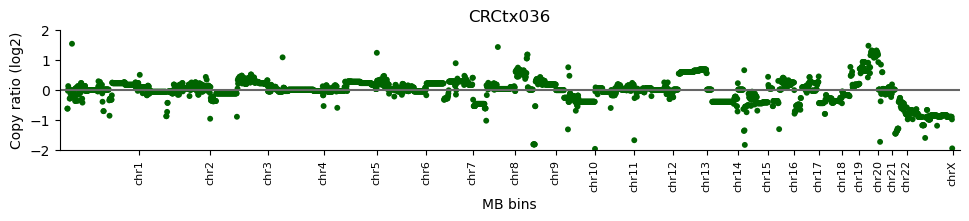

CRCtx027


/home/judith/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/judith/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/judith/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/judith/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDty

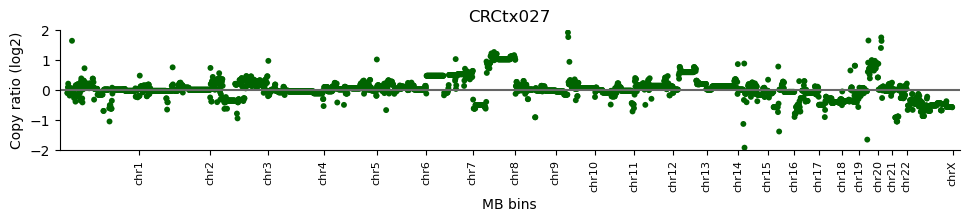

CRCtx033


/home/judith/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/judith/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/judith/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/judith/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDty

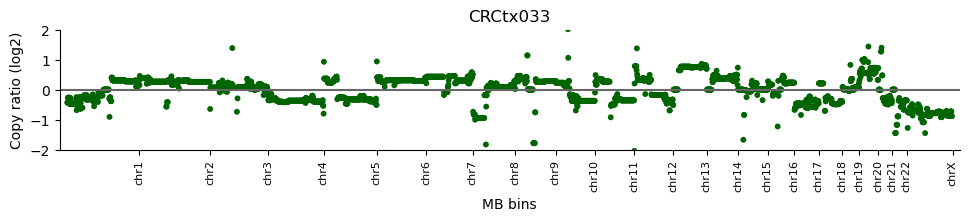

CRCtx054


/home/judith/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/judith/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/judith/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/judith/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDty

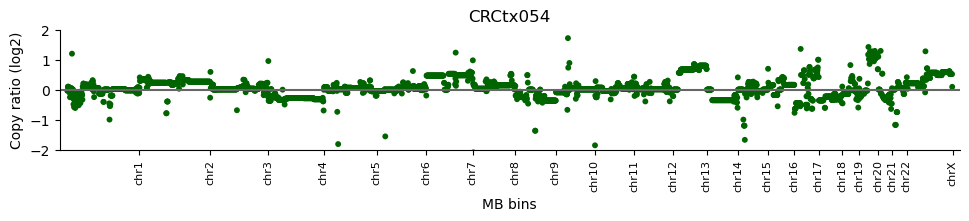

CRCtx047


/home/judith/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/judith/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/judith/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/judith/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDty

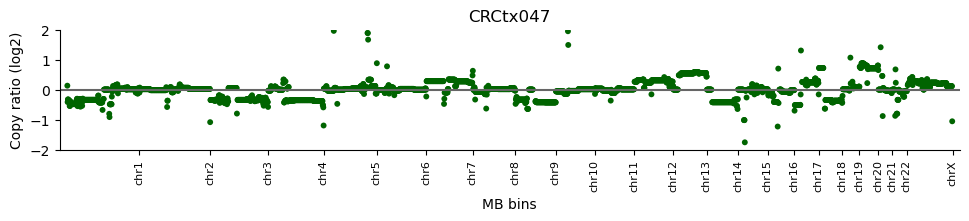

CRCtx028


/home/judith/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/judith/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/judith/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/judith/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDty

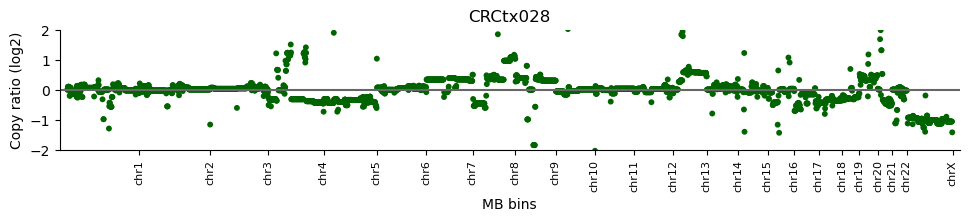

CRCtx021


/home/judith/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/judith/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/judith/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/judith/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDty

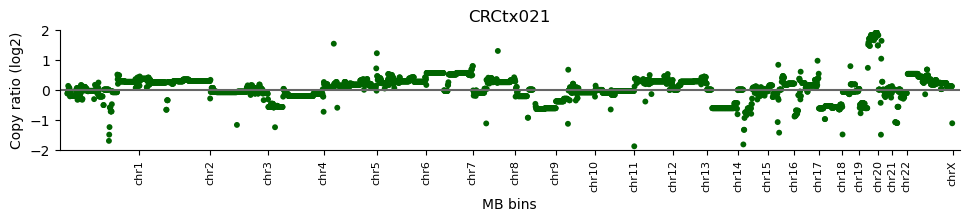

In [35]:
for i in df.columns:
    if i != 'Xpos':
        df1 = df[[i,'Xpos']]
        print (i)
        fig_generator(df1,i, sorted_chromosome_series)

In [27]:
df=df.drop(['Xpos'],axis=1)

In [28]:
df.to_csv('CNVPerMB_allsamples.tsv',sep='\t')

In [29]:
df

##Calling copy number with thresholds: 
# -1.1 => 0,
# -0.25 => 1,
# 0.2 => 2, 
# 0.7 => 3

,CRCtx026,CRCtx029,CRCtx040,CRCtx055,CRCtx053,CRCtx036,CRCtx027,CRCtx033,CRCtx054,CRCtx047,CRCtx028,CRCtx021
chr1:0-1000000,-0.157071,0.032018,-0.781829,-0.078174,-0.163742,-0.634414,-0.112402,-0.433232,-0.036448,0.130735,-0.002830,-0.128262
chr1:1000000-2000000,-0.152804,0.032018,-0.781829,-0.021339,-0.163742,-0.634414,-0.112402,-0.433232,-0.036448,-0.415981,-0.002830,-0.128262
chr1:2000000-3000000,0.067672,0.071337,-0.684721,0.073458,-0.046488,-0.040226,0.071098,-0.271293,0.096818,-0.327430,0.093991,-0.048089
chr1:3000000-4000000,0.067672,0.204736,-0.684721,0.073458,-0.046488,0.116869,0.197891,-0.271293,0.096818,-0.327430,0.093991,0.123585
chr1:4000000-5000000,0.020703,0.076112,-0.733711,0.073458,-0.046488,0.024902,0.095227,-0.271293,0.079439,-0.360787,0.093991,-0.052447
...,...,...,...,...,...,...,...,...,...,...,...,...
chrX:152000000-153000000,0.025740,0.276904,0.361082,-0.118763,-0.354451,-0.906524,-0.579680,-0.729818,0.517180,0.114478,-1.065000,0.110106
chrX:153000000-154000000,0.025740,0.276904,0.361082,-0.118763,-0.354451,-0.906524,-0.579680,-0.885089,0.517180,0.114478,-1.065000,0.110106
chrX:154000000-155000000,0.025740,0.276904,0.353186,-0.118763,-0.354451,-0.993029,-0.579680,-0.885089,0.517180,0.114478,-1.065000,0.110106
chrX:155000000-156000000,-0.410962,-0.686172,0.022781,-1.038000,-1.384590,-1.959350,-0.590785,-2.202580,0.092195,-1.056740,-1.424380,-1.122460
